Step 4: In this phase different optimizers will be implemented for the 6 models from Step 3.

In [7]:
# Import libraries

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import plot_model



import tensorflow_datasets as tfds

In [9]:
# Load the data

p_camelyon, p_camelyon_info = tfds.load("patch_camelyon", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete7L8A5G/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete7L8A5G/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete7L8A5G/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [10]:
# Defining a "normalize" function to process the data before feeding it into the deep neural network. 

def normalize(x):
  image, label = x['image'], x['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.one_hot(label, 2, dtype=tf.float32)
  return image, label

In [11]:
# Applying "normalize" function along with others to the data

# Processing the training dataset
train_ds = p_camelyon['train'].map(normalize, num_parallel_calls=8)
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(64)
train_ds = train_ds.prefetch(2)

# Processing validation dataset
validation_ds = p_camelyon['validation'].map(normalize, num_parallel_calls=8)
validation_ds = validation_ds.repeat()
validation_ds = validation_ds.batch(128)
validation_ds = validation_ds.prefetch(2)

#Processing the test dataset
test_ds = p_camelyon['test'].map(normalize, num_parallel_calls=8)
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(2)

#Seperating image and label into different variables
train_images, train_labels = next(iter(train_ds))
valid_images, valid_labels = next(iter(validation_ds))
test_images, test_labels  = next(iter(test_ds))


In [14]:
import math

batch_size_for_training = 32
batch_size_for_validation = 128
batch_size_for_test = 128

training_size = 262144
validation_size = 32768
test_size =  32768
        

# Calculate steps for training and testing the model
calculate_steps_training = lambda x: int(math.ceil(1. * x / batch_size_for_training))
calculate_steps_validation = lambda x: int(math.ceil(1. * x / batch_size_for_validation))
calculate_steps_test= lambda x: int(math.ceil(1. * x / batch_size_for_test))

steps_per_epoch = calculate_steps_training(training_size) 
validation_steps = calculate_steps_validation(validation_size)
steps = calculate_steps_test(test_size)

print("Training steps: ", steps_per_epoch)
print("Validation steps: ", validation_steps)
print("Testing steps: ", steps)


Training steps:  8192
Validation steps:  256
Testing steps:  256


In [13]:
import matplotlib.pyplot as plt

def plot_hist(history):
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

In [29]:
from tensorflow.keras.layers import MaxPool2D

# Building the Convolutonal Neural Network Model 1 Version 1

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Rely activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

#Optimiser = adam
model_1_version_1 = Model(inputs=input, outputs = output)
model_1_version_1.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_1_version_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 20, 20, 64)        1849

In [30]:
# Building the Convolutonal Neural Network Model 2 Version 1

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Sigmoid activation functions only with softmax for the last Dense layer

x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
model_2_version_1 = Model(inputs=input, outputs = output)
model_2_version_1.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_2_version_1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 20, 20, 64)        1849

In [31]:
# Building the Convolutonal Neural Network Model 3 Version 1

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# A conbination of relu and sigmoid activation functions
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
model_3_version_1 = Model(inputs=input, outputs = output)
model_3_version_1.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_3_version_1.summary()
#plot_model(model_3_version_1)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 20, 20, 64)        1849

Epoch 1/10
8192/8192 [==============================] - 172s 21ms/step - loss: 0.3546 - acc: 0.8471 - val_loss: 0.3814 - val_acc: 0.8395
Epoch 2/10
8192/8192 [==============================] - 174s 21ms/step - loss: 0.2409 - acc: 0.9041 - val_loss: 0.4142 - val_acc: 0.8315
Epoch 3/10
8192/8192 [==============================] - 173s 21ms/step - loss: 0.1920 - acc: 0.9260 - val_loss: 0.4791 - val_acc: 0.8319
Epoch 4/10
8192/8192 [==============================] - 174s 21ms/step - loss: 0.1534 - acc: 0.9420 - val_loss: 0.5844 - val_acc: 0.8262
Epoch 5/10
8192/8192 [==============================] - 174s 21ms/step - loss: 0.1219 - acc: 0.9545 - val_loss: 0.4901 - val_acc: 0.8333
Epoch 6/10
8192/8192 [==============================] - 195s 24ms/step - loss: 0.1000 - acc: 0.9636 - val_loss: 0.7596 - val_acc: 0.8034
Epoch 7/10
8192/8192 [==============================] - 172s 21ms/step - loss: 0.0825 - acc: 0.9701 - val_loss: 0.6172 - val_acc: 0.8341
Epoch 8/10
8192/8192 [===================

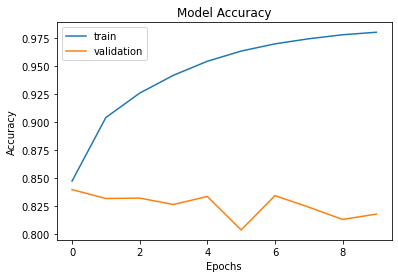

In [32]:
# Training the model 2 Version 1
history_1_version_1= model_1_version_1.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_1_version_1)

Epoch 1/10
8192/8192 [==============================] - 196s 24ms/step - loss: 0.6937 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 2/10
8192/8192 [==============================] - 169s 21ms/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 3/10
8192/8192 [==============================] - 172s 21ms/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 4/10
8192/8192 [==============================] - 174s 21ms/step - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 5/10
8192/8192 [==============================] - 174s 21ms/step - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 6/10
8192/8192 [==============================] - 176s 21ms/step - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 7/10
8192/8192 [==============================] - 178s 22ms/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 8/10
8192/8192 [===================

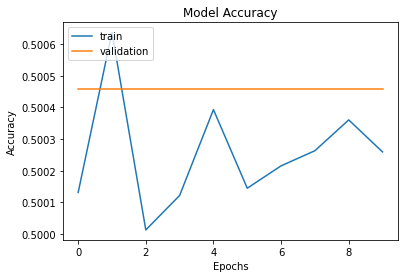

In [20]:
# Training the model 2 Version 1
history_2_version_1= model_2_version_1.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_2_version_1)

Epoch 1/10
8192/8192 [==============================] - 171s 21ms/step - loss: 0.5395 - acc: 0.7160 - val_loss: 0.4428 - val_acc: 0.7844
Epoch 2/10
8192/8192 [==============================] - 173s 21ms/step - loss: 0.4126 - acc: 0.8150 - val_loss: 0.4486 - val_acc: 0.7950
Epoch 3/10
8192/8192 [==============================] - 174s 21ms/step - loss: 0.3689 - acc: 0.8387 - val_loss: 0.4201 - val_acc: 0.7971
Epoch 4/10
8192/8192 [==============================] - 177s 22ms/step - loss: 0.3400 - acc: 0.8532 - val_loss: 0.4180 - val_acc: 0.8065
Epoch 5/10
8192/8192 [==============================] - 175s 21ms/step - loss: 0.3169 - acc: 0.8651 - val_loss: 0.4217 - val_acc: 0.7968
Epoch 6/10
8192/8192 [==============================] - 196s 24ms/step - loss: 0.2971 - acc: 0.8757 - val_loss: 0.4106 - val_acc: 0.8165
Epoch 7/10
8192/8192 [==============================] - 174s 21ms/step - loss: 0.2797 - acc: 0.8845 - val_loss: 0.4530 - val_acc: 0.7946
Epoch 8/10
8192/8192 [===================

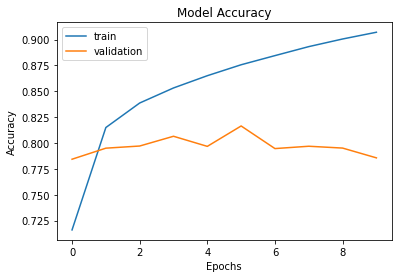

In [21]:
# Training the model 3 Version 2
history_3_version_1= model_3_version_1.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_3_version_1)

In [33]:
# Saving the models

import joblib

joblib.dump(model_1_version_1, 'model_1_version_1')
joblib.dump(model_2_version_1, 'model_2_version_1')
joblib.dump(model_3_version_1, 'model_3_version_1')

INFO:tensorflow:Assets written to: ram://4eeba170-4949-443a-a5b6-be72cd14bfde/assets


INFO:tensorflow:Assets written to: ram://4eeba170-4949-443a-a5b6-be72cd14bfde/assets


INFO:tensorflow:Assets written to: ram://2ebe753d-8e61-4536-92d9-67bf941c5af1/assets


INFO:tensorflow:Assets written to: ram://2ebe753d-8e61-4536-92d9-67bf941c5af1/assets


INFO:tensorflow:Assets written to: ram://187aa0c0-4167-49ff-8acd-d90397a82f7e/assets


INFO:tensorflow:Assets written to: ram://187aa0c0-4167-49ff-8acd-d90397a82f7e/assets


['model_3_version_1']

In [34]:
# Loading the models

model_1_version_1_object = joblib.load('model_1_version_1')
model_2_version_1_object = joblib.load('model_2_version_1')
model_3_version_1_object = joblib.load('model_3_version_1')

In [36]:
# Evaluating the models

print("Test dataset accuracy for model 1 version 1 is: {0:.4f}".format(model_1_version_1_object.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 2 version 1 is: {0:.4f}".format(model_2_version_1_object.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 3 version 1 is: {0:.4f}".format(model_3_version_1_object.evaluate(test_ds, steps=steps, verbose=1)[1]))

256/256 [==============================] - 9s 36ms/step - loss: 1.3001 - acc: 0.7890
Test dataset accuracy for model 1 version 1 is: 0.7890
256/256 [==============================] - 9s 36ms/step - loss: 0.7683 - acc: 0.4998
Test dataset accuracy for model 2 version 1 is: 0.4998
256/256 [==============================] - 10s 37ms/step - loss: 0.7148 - acc: 0.5002
Test dataset accuracy for model 3 version 1 is: 0.5002
